### Import Required Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow.random import set_seed
import warnings
warnings.filterwarnings('ignore')

### Data Collection

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
set_seed(42)

# Download stock data
ticker_symbol = 'GOOGL'
ticker_data = yf.Ticker(ticker_symbol)
df = ticker_data.history(period='1d', start='2015-11-01', end='2023-11-25')
df.reset_index(inplace=True)
df = df[['Date', 'Close']]
df

,Date,Close
0,2015-11-02 00:00:00-05:00,37.387001
1,2015-11-03 00:00:00-05:00,37.441002
2,2015-11-04 00:00:00-05:00,37.765499
3,2015-11-05 00:00:00-05:00,38.033501
4,2015-11-06 00:00:00-05:00,38.080002
...,...,...
2025,2023-11-17 00:00:00-05:00,135.309998
2026,2023-11-20 00:00:00-05:00,136.250000
2027,2023-11-21 00:00:00-05:00,136.970001
2028,2023-11-22 00:00:00-05:00,138.490005


### Data Preprocessing

In [3]:
# Data is scaled to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
training_data_len = int(np.ceil(len(df) * 0.8))
scaler.fit(df['Close'].values[:training_data_len].reshape(-1, 1))
scaled_data = scaler.transform(df['Close'].values.reshape(-1, 1))

In [4]:
# Create the training and testing data set
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]

In [5]:
# Split the data into x_train, y_train, x_test, and y_test data sets
x_train, y_train = [], []
x_test, y_test = [], df['Close'][training_data_len:].values
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [6]:
# Convert to numpy arrays for the Gradient Boosting model
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)

### Build the Gradient Boosting Model

In [7]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(x_train, y_train)

GradientBoostingRegressor(random_state=42)

### Evaluate the Model and Print RMSE

In [8]:
# Predict on training set and test set
train_predictions = model.predict(x_train).reshape(-1, 1)
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = model.predict(x_test).reshape(-1, 1)
test_predictions = scaler.inverse_transform(test_predictions)

In [9]:
# Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(df['Close'][:training_data_len][60:], train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

Train RMSE: 0.8066827522091898, Test RMSE: 7.990517304688029


### Visualize the Training Data and Predictions

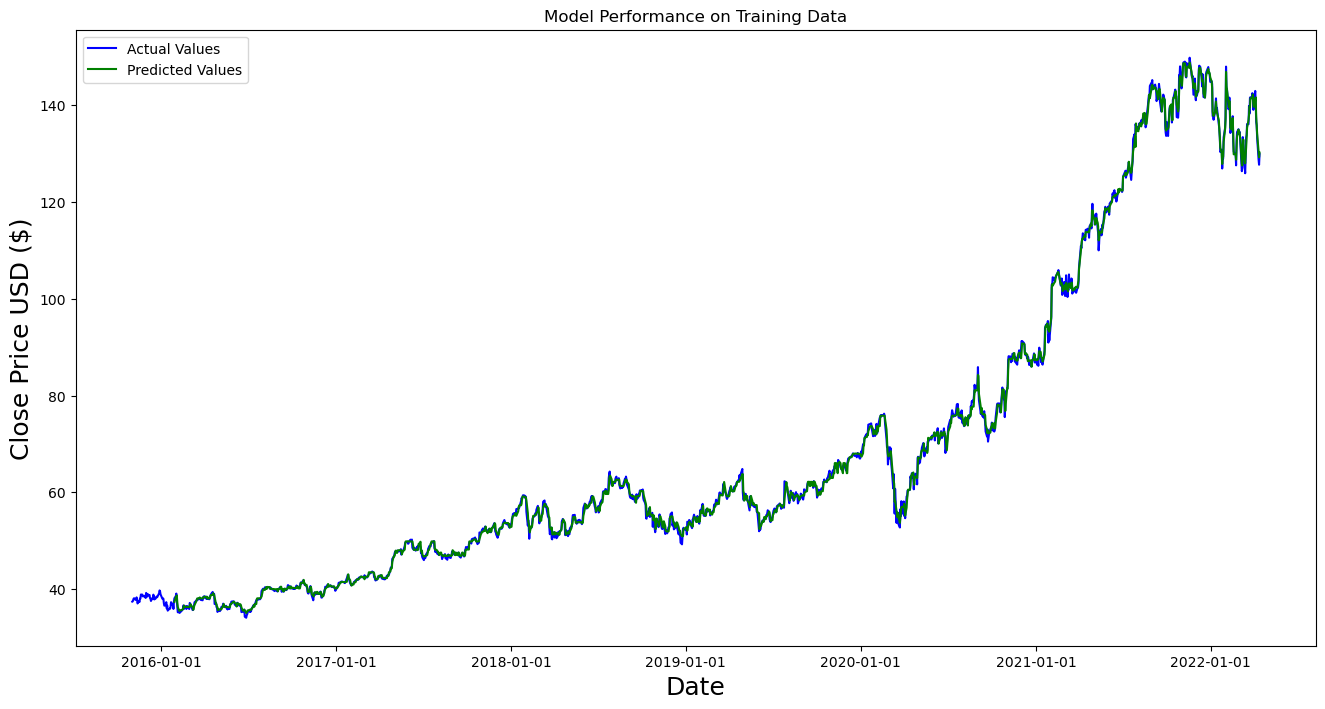

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
adjusted_train_dates = df['Date'][60:training_data_len]

plt.figure(figsize=(16, 8))
plt.title('Model Performance on Training Data')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(df['Date'][:training_data_len], df['Close'][:training_data_len], label='Actual Values', color='blue')
plt.plot(adjusted_train_dates, train_predictions, label='Predicted Values', color='green')
plt.legend()
plt.show()

### Forecasting the Next 365 Days with Gradient Boosting

In [11]:
# Get the last 60 days of the scaled data for the initial prediction
last_60_days = scaled_data[-60:]
predicted_prices = []

for i in range(365):
    X_pred_scaled = last_60_days.reshape(1, -1)
    pred_price_scaled = model.predict(X_pred_scaled)
    predicted_prices.append(pred_price_scaled[0])
    last_60_days = np.append(last_60_days, pred_price_scaled)[1:].reshape(-1, 1)

# Inverse transform the predicted prices to the original scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Get the last date from the dataset
last_date = pd.to_datetime(df['Date'].iloc[-1])
prediction_dates = [last_date + pd.Timedelta(days=x + 1) for x in range(365)]
predicted_prices = predicted_prices.flatten()

# Print the predicted prices
for i in range(len(prediction_dates)):
    print(f"Predicted closing price for {prediction_dates[i].date()}: ${predicted_prices[i]:.2f}")

Predicted closing price for 2023-11-25: $137.03
Predicted closing price for 2023-11-26: $138.39
Predicted closing price for 2023-11-27: $139.58
Predicted closing price for 2023-11-28: $140.80
Predicted closing price for 2023-11-29: $139.87
Predicted closing price for 2023-11-30: $140.58
Predicted closing price for 2023-12-01: $139.53
Predicted closing price for 2023-12-02: $140.04
Predicted closing price for 2023-12-03: $140.30
Predicted closing price for 2023-12-04: $140.44
Predicted closing price for 2023-12-05: $140.31
Predicted closing price for 2023-12-06: $140.22
Predicted closing price for 2023-12-07: $140.52
Predicted closing price for 2023-12-08: $140.27
Predicted closing price for 2023-12-09: $140.11
Predicted closing price for 2023-12-10: $140.11
Predicted closing price for 2023-12-11: $140.73
Predicted closing price for 2023-12-12: $140.77
Predicted closing price for 2023-12-13: $140.77
Predicted closing price for 2023-12-14: $140.88
Predicted closing price for 2023-12-15: 

### Visualize the Test Data and 365-Day Forecast

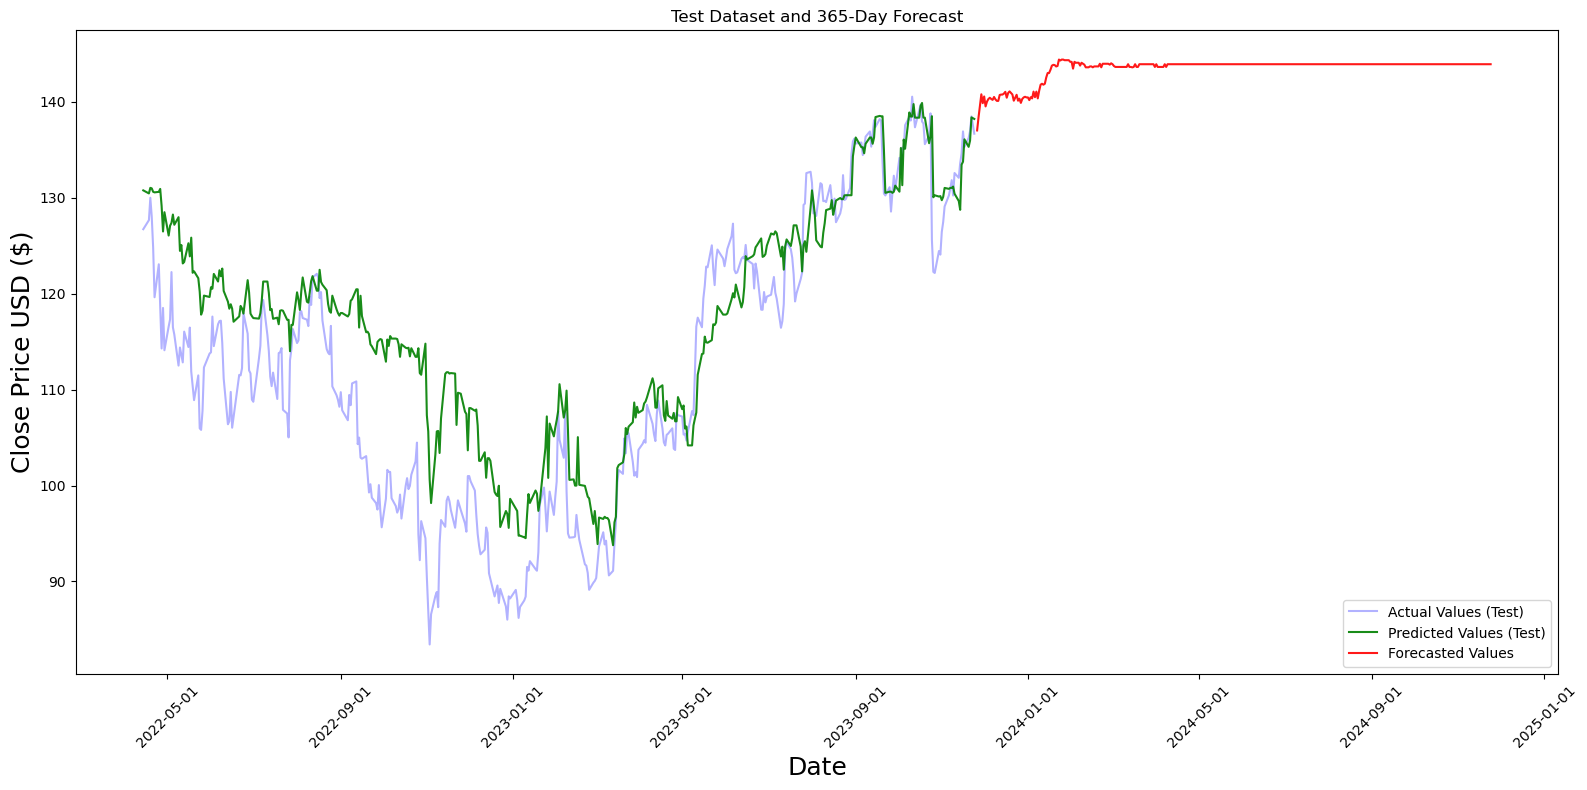

In [12]:
# Prepare the dates for forecasting by extending the existing dates array
forecast_dates = [df['Date'].iloc[-1] + pd.Timedelta(days=x + 1) for x in range(1, 366)]

plt.figure(figsize=(16, 8))
plt.title('Test Dataset and 365-Day Forecast')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(df['Date'][training_data_len:], y_test, label='Actual Values (Test)', color='Blue', alpha=0.3)
plt.plot(df['Date'][training_data_len:], test_predictions, label='Predicted Values (Test)', color='Green', alpha=0.9)
plt.plot(forecast_dates, predicted_prices, label='Forecasted Values', color='Red', alpha=0.9)

plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()